<a href="https://colab.research.google.com/github/Manav-Gupta/asteroid-LSTM/blob/main/Asteroid_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mounting the drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing all the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
import keras
from pandas import DataFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from datetime import datetime
from sklearn.decomposition import PCA

In [3]:
# reading the dataset
dataset=pd.read_csv('drive/My Drive/results.csv')
dataset.head(5)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,26,33,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,full_name,a,e,i,om,w,q,ad,per_y,data_arc,condition_code,n_obs_used,n_del_obs_used,n_dop_obs_used,H,neo,full_name.1,a.1,e.1,i.1,om.1,w.1,q.1,ad.1,per_y.1,data_arc.1,condition_code.1,n_obs_used.1,n_del_obs_used.1,n_dop_obs_used.1,H.1,pha,diameter,extent,albedo,rot_per,GM,BV,UB,IR,spec_B,spec_T,G,moid,class,n,ma,diameter_sigma,per
0,1 Ceres (A801 AA),2.769165,0.076009,10.594067,80.305531,73.597695,2.558684,2.979647,4.608202,9242.0,0,1030,60.0,0.0,3.40,N,1 Ceres (A801 AA),2.769165,0.076009,10.594067,80.305531,73.597695,2.558684,2.979647,4.608202,9242.0,0,1030,60.0,0.0,3.40,N,939.400,964.4 x 964.2 x 891.8,0.0900,9.074170,62.6284,0.713,0.426,NaN,C,G,0.12,1.59478,MBA,0.213885,77.372098,0.200,1683.145703
1,2 Pallas (A802 FA),2.773841,0.229972,34.832931,173.024741,310.202392,2.135935,3.411748,4.619880,78910.0,0,8516,NaN,NaN,4.20,N,2 Pallas (A802 FA),2.773841,0.229972,34.832931,173.024741,310.202392,2.135935,3.411748,4.619880,78910.0,0,8516,NaN,NaN,4.20,N,545.000,582x556x500,0.1010,7.813200,14.3000,0.635,0.284,NaN,B,B,0.11,1.23429,MBA,0.213345,144.975676,18.000,1687.410992
2,3 Juno (A804 RA),2.668285,0.256936,12.991043,169.851484,248.066191,1.982706,3.353865,4.358696,78858.0,0,7240,NaN,NaN,5.33,N,3 Juno (A804 RA),2.668285,0.256936,12.991043,169.851484,248.066191,1.982706,3.353865,4.358696,78858.0,0,7240,NaN,NaN,5.33,N,246.596,NaN,0.2140,7.210000,NaN,0.824,0.433,NaN,Sk,S,0.32,1.03429,MBA,0.226129,125.435355,10.594,1592.013769
3,4 Vesta (A807 FA),2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,25372.0,0,9397,2977.0,0.0,3.00,N,4 Vesta (A807 FA),2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,25372.0,0,9397,2977.0,0.0,3.00,N,525.400,572.6 x 557.2 x 446.4,0.4228,5.342128,17.8000,0.782,0.492,NaN,V,V,0.32,1.13948,MBA,0.271609,95.861938,0.200,1325.432763
4,5 Astraea (A845 XA),2.574037,0.190913,5.367427,141.571025,358.648419,2.082619,3.065455,4.129814,63739.0,0,3082,NaN,NaN,6.90,N,5 Astraea (A845 XA),2.574037,0.190913,5.367427,141.571025,358.648419,2.082619,3.065455,4.129814,63739.0,0,3082,NaN,NaN,6.90,N,106.699,NaN,0.2740,16.806000,NaN,0.826,0.411,NaN,S,S,NaN,1.09575,MBA,0.238661,17.846344,3.140,1508.414420


In [4]:
# dropping any unncessary columns that are not required for the analysis
dataset.drop(columns=['condition_code','n_obs_used','n_del_obs_used','n_dop_obs_used','condition_code.1','a.1','e.1','i.1','om.1','w.1','q.1','ad.1','per_y.1','data_arc.1','condition_code.1','n_obs_used.1','n_del_obs_used.1','n_dop_obs_used.1','H.1','extent','pha','neo','IR','full_name','full_name.1'],inplace=True)

In [5]:
# comverting diameter and other object data types to numberic
dataset['diameter']=pd.to_numeric(dataset['diameter'],errors='coerce')
dataset['spec_B']=pd.to_numeric(dataset['spec_B'],errors='coerce')
dataset['spec_T']=pd.to_numeric(dataset['spec_T'],errors='coerce')
dataset['class']=pd.to_numeric(dataset['class'],errors='coerce')

In [6]:
# deleting any rows where diameter contains NaN values
dataset = dataset[dataset['diameter'].notnull()]  

In [7]:
# checking for the percentage of NaN values in different columns
for column in dataset.columns:
    print(column, dataset[column].isna().sum()/dataset.shape[0])

a 0.0
e 0.0
i 0.0
om 0.0
w 0.0
q 0.0
ad 0.0
per_y 0.0
data_arc 0.0003856784727132481
H 0.020055280581088897
diameter 0.0
albedo 0.008249233999700028
rot_per 0.9028018826823223
GM 0.9999000092848521
BV 0.9928078107032918
UB 0.9931006406547963
spec_B 1.0
spec_T 1.0
G 0.9991500789212431
moid 0.0
class 1.0
n 0.0
ma 0.0
diameter_sigma 0.0008999164363309121
per 0.0


In [8]:
# deleting any columns with more than 50% missing values
tooMuchNa = dataset.columns[dataset.isna().sum()/dataset.shape[0] > 0.5]
dataset = dataset.drop(tooMuchNa,axis=1)

In [9]:
# filling the missing values of H column with the mode of the entire column
dataset.columns
dataset=dataset.fillna(dataset['H'].mode())

In [10]:
# filling all the missing values from the remaining columns with the mean of the their respective columns
dataset=dataset.fillna(dataset.mean())

In [11]:
dataset.columns

Index(['a', 'e', 'i', 'om', 'w', 'q', 'ad', 'per_y', 'data_arc', 'H',
       'diameter', 'albedo', 'moid', 'n', 'ma', 'diameter_sigma', 'per'],
      dtype='object')

In [12]:
# extracting the correlation matrix to determine what features that the diameter depends on
datasetc=dataset.corr()
datasetc

,a,e,i,om,w,q,ad,per_y,data_arc,H,diameter,albedo,moid,n,ma,diameter_sigma,per
a,1.000000,0.010390,0.151783,-0.000351,-0.002328,0.373626,0.984952,0.938924,-0.026846,-0.130929,0.147350,-0.116290,0.377739,-0.279414,0.008972,0.201096,0.938924
e,0.010390,1.000000,0.166829,0.002089,0.011458,-0.540449,0.111654,0.044451,-0.050940,0.253444,-0.060931,-0.021583,-0.510767,0.215717,-0.010984,-0.016787,0.044451
i,0.151783,0.166829,1.000000,-0.012432,-0.005921,0.079005,0.145345,0.096666,-0.188332,-0.044018,0.051276,-0.083805,0.120690,-0.103634,0.013371,0.040714,0.096666
om,-0.000351,0.002089,-0.012432,1.000000,-0.106782,-0.003238,0.000233,0.000462,0.001219,0.001032,0.001067,0.000808,-0.003897,0.006615,0.004238,-0.001849,0.000462
w,-0.002328,0.011458,-0.005921,-0.106782,1.000000,-0.006230,-0.001295,-0.001636,-0.006138,-0.008628,0.003238,-0.002874,-0.006063,0.003440,-0.001147,0.001718,-0.001636
q,0.373626,-0.540449,0.079005,-0.003238,-0.006230,1.000000,0.207692,0.111740,-0.023898,-0.379637,0.327952,-0.263136,0.996172,-0.688114,0.052792,0.360839,0.111740
ad,0.984952,0.111654,0.145345,0.000233,-0.001295,0.207692,1.000000,0.969338,-0.023858,-0.067338,0.094286,-0.073607,0.212742,-0.166450,-0.000375,0.144837,0.969338
per_y,0.938924,0.044451,0.096666,0.000462,-0.001636,0.111740,0.969338,1.000000,-0.009247,-0.036027,0.050428,-0.020811,0.113728,-0.059722,-0.005902,0.081167,1.000000
data_arc,-0.026846,-0.050940,-0.188332,0.001219,-0.006138,-0.023898,-0.023858,-0.009247,1.000000,-0.638377,0.488664,0.249080,-0.032765,0.053101,-0.023520,0.011496,-0.009247
H,-0.130929,0.253444,-0.044018,0.001032,-0.008628,-0.379637,-0.067338,-0.036027,-0.638377,1.000000,-0.563871,-0.221431,-0.373016,0.313851,0.009083,-0.080778,-0.036027


In [13]:
# establishing the test dataset of features
dataset1 = dataset[['a','i','q','ad','data_arc','moid','diameter_sigma']]
print(dataset.head(20))

           a         e          i  ...          ma  diameter_sigma          per
0   2.769165  0.076009  10.594067  ...   77.372098        0.200000  1683.145703
1   2.773841  0.229972  34.832931  ...  144.975676       18.000000  1687.410992
2   2.668285  0.256936  12.991043  ...  125.435355       10.594000  1592.013769
3   2.361418  0.088721   7.141771  ...   95.861938        0.200000  1325.432763
4   2.574037  0.190913   5.367427  ...   17.846344        3.140000  1508.414420
5   2.424533  0.203219  14.739653  ...  190.686496        2.900000  1378.924506
6   2.387375  0.230145   5.521598  ...  247.425812       10.000000  1347.347071
7   2.201415  0.155833   5.889081  ...  315.318013        1.025000  1193.029574
8   2.386189  0.123300   5.576494  ...   23.912205        0.485994  1346.343281
9   3.142435  0.112117   3.831786  ...  222.850543        6.800000  2034.688644
10  2.452390  0.099823   4.631823  ...   21.701825        1.008000  1402.757738
11  2.333778  0.220439   8.372749  ...  

In [14]:
# Establishing the test dataset for the output
dataset2=dataset['diameter'].values
dataset.head()

,a,e,i,om,w,q,ad,per_y,data_arc,H,diameter,albedo,moid,n,ma,diameter_sigma,per
0,2.769165,0.076009,10.594067,80.305531,73.597695,2.558684,2.979647,4.608202,9242.0,3.40,939.400,0.0900,1.59478,0.213885,77.372098,0.200,1683.145703
1,2.773841,0.229972,34.832931,173.024741,310.202392,2.135935,3.411748,4.619880,78910.0,4.20,545.000,0.1010,1.23429,0.213345,144.975676,18.000,1687.410992
2,2.668285,0.256936,12.991043,169.851484,248.066191,1.982706,3.353865,4.358696,78858.0,5.33,246.596,0.2140,1.03429,0.226129,125.435355,10.594,1592.013769
3,2.361418,0.088721,7.141771,103.810804,150.728541,2.151909,2.570926,3.628837,25372.0,3.00,525.400,0.4228,1.13948,0.271609,95.861938,0.200,1325.432763
4,2.574037,0.190913,5.367427,141.571025,358.648419,2.082619,3.065455,4.129814,63739.0,6.90,106.699,0.2740,1.09575,0.238661,17.846344,3.140,1508.414420


In [15]:
#Scaling data
scale_x = MinMaxScaler(feature_range=(0,1))
scaled_x=scale_x.fit_transform(dataset1)
print(scaled_x.shape)
dataset2=dataset2.reshape(-1, 1)
scale_y = MinMaxScaler(feature_range=(0,1))
scaled_y=scale_y.fit_transform(dataset2)
print(scaled_y.shape)
print(scaled_x)

(140013, 7)
(140013, 1)
[[0.00570697 0.06207417 0.06155793 ... 0.11710958 0.04051714 0.00142857]
 [0.00571942 0.20439407 0.05105128 ... 1.         0.03135834 0.12857143]
 [0.00543831 0.07614815 0.04724305 ... 0.99934101 0.02627704 0.07567143]
 ...
 [0.0054638  0.09806536 0.04831215 ... 0.08976162 0.02666169 0.00346429]
 [0.00576988 0.05069223 0.05655463 ... 0.04762448 0.03484691 0.00605714]
 [0.00561283 0.08861884 0.04893609 ... 0.06646897 0.02860504 0.00138571]]


In [16]:
#Converting data into readable format of LSTM for previous 24 timesteps
x=list()
y=list()
ws=100
for i in range(len(dataset)-ws):
  xx=list()
  for j in range(0,ws-1,1):
    value=scaled_x[i+j]
    xx.append(value)
  x.append(xx)
  yy=scaled_y[i+ws-1]
  y.append(yy)
#Input of  LSTM 
x=np.array(x)
#Output of LSTM
y=np.array(y)
print(x.shape)

(139913, 99, 7)


In [17]:
#Splitting data into training 70% , testing 15% and validation 15%
n_train_hours = 97931
n_valid_hours = 118917

train_x = x[:n_train_hours]
test_x = x[n_valid_hours:]
valid_x= x[n_train_hours:n_valid_hours]

train_y = y[:n_train_hours]
test_y = y[n_valid_hours:]
valid_y= y[n_train_hours:n_valid_hours]

Epoch 1/300
4/4 [==============================] - 2s 318ms/step - loss: 0.0603 - val_loss: 0.0173
Epoch 2/300
4/4 [==============================] - 1s 214ms/step - loss: 0.0081 - val_loss: 0.0055
Epoch 3/300
4/4 [==============================] - 1s 207ms/step - loss: 0.0106 - val_loss: 0.0135
Epoch 4/300
4/4 [==============================] - 1s 244ms/step - loss: 0.0171 - val_loss: 0.0179
Epoch 5/300
4/4 [==============================] - 1s 208ms/step - loss: 0.0140 - val_loss: 0.0080
Epoch 6/300
4/4 [==============================] - 1s 213ms/step - loss: 0.0087 - val_loss: 0.0050
Epoch 7/300
4/4 [==============================] - 1s 209ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 8/300
4/4 [==============================] - 1s 212ms/step - loss: 0.0049 - val_loss: 0.0035
Epoch 9/300
4/4 [==============================] - 1s 208ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 10/300
4/4 [==============================] - 1s 214ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 11/

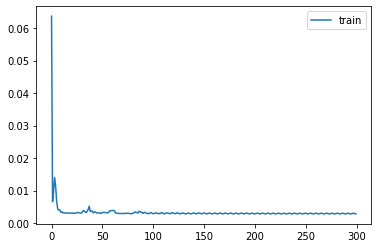

In [20]:
#Declarationof model
model = Sequential()
#adding LSTM layer
model.add(LSTM(64, input_shape=(9,7),kernel_initializer='truncated_normal'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mae', optimizer=Adam(lr=0.01))
#Training the model
history = model.fit(train_x, train_y, epochs=300, batch_size=25000, validation_data=(valid_x, valid_y), verbose=1, shuffle=False)
#Plotting the loss graphs
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [21]:
#Rescaling the data 
import sklearn.metrics as metrics
yhat = model.predict(test_x)

inv_yhat = scale_y.inverse_transform(yhat)

inv_y = scale_y.inverse_transform(test_y)

#Finding the accuracy with RMSE function
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1.737


In [22]:
# Calculating nRMSE
nrmse=rmse/np.mean(inv_y)
nrmse

0.5905229212637421